# A Study on optimizers and how they behave

Here I will be exploring some of the most commonly used optimization algorithms in deep learning to understand their behaviour when trying to find a global minimum in a function space.
- Gradient Descent
- Gradient Descent with Momentum
- RMSProp
- Adam Optimizer

## Motivation

The main motivation for this project is to intuitively understand what is going on under the hood when we implement any one of these optimization algorithms. When looking at these concepts on paper, it is easy to take for granted that they "just work" without knowing **why** they work the way they do. It is important to understand what each of these algorithms aim to do and how they aid in training a deep learning model.

## The problem statement

In most deep learning applications we are required to train a model by looking at its **loss function** and trying to find the most optimal point in them. In al lot of these cases, the functions we are working with are't a straightforward curve with a global minimum point like what we are working with here. They tend to have saddle points where the model struggles to find its way towards the minimum. This is where optimization algorithms find their use.

For this demonstration, we will be usig a toy function known as the Matyas function, which is of the form

$$f(x,y) = 0.26(x^{2}+y^{2}) - 0.48xy$$

and its global minimum lies at $(0,0)$.

We first import the packages we need to make this work. Luckily since we are doing this from scratch, don't have to use too many of them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from pprint import pprint

# %matplotlib qt
%matplotlib inline


Here we implement the matyas function along with its derivatives, the weighted average calculator and finally, the backpropagation function that helps us with the root finding process on the surface of the matyas function.

In [2]:
def matyas(a):
    return 0.26*(a[0]**2 + a[1]**2) - 0.48*a[0]*a[1]


def matyas_derivatives(a):
    dx = 0.52*a[0] - 0.48*a[1]
    dy = 0.52*a[1] - 0.48*a[0]
    return dx, dy

def get_weighted_average(v_prev, beta, dtheta):
    return beta*v_prev + ((1-beta)*dtheta)

def descend(a, alpha=0.4, beta1 = 0.90, beta2 = 0.98, iter=5000, optimizer = 'GD'):
    ai = []
    f = matyas(a)
    da = 0
    epsilon = 10**(-7)
    vda = 0
    sda = 0

    for i in range(1,iter+1):
        f = matyas(a)
        
        # if (ai[-1][1] < 10^(-1)):
        #     break

        da = np.array(matyas_derivatives(a))

        if (optimizer == 'GD'):
            ai.append([a,f,da,vda,sda])
            a = a - np.dot(alpha,da)
        elif (optimizer == 'momentum'):
            vda = get_weighted_average(vda, beta1, da)
            ai.append([a,f,da,vda])
            a = a - np.dot(alpha,vda)
        elif (optimizer == 'rmsprop'):
            sda = get_weighted_average(sda, beta2, da**2)
            ai.append([a,f,da,sda, alpha/(np.sqrt(sda) + epsilon)])
            a = a - (np.dot(alpha,da)/(np.sqrt(sda) + epsilon))
        elif (optimizer == 'adam'):
            vda = get_weighted_average(vda, beta1, da)/(1 - (beta1**iter))
            sda = get_weighted_average(sda, beta2, da**2)/(1 - (beta2**iter))
            ai.append([a,f,da,vda,sda, alpha/(np.sqrt(sda) + epsilon)])
            a = a - (np.dot(alpha,vda)/(np.sqrt(sda) + epsilon))

    # ai = np.array(ai)
    return ai



We now take the point (-6,10) as our starting point and begin the process of descending down the curve using the optimization algorithms mentioned before.

We receieve the following as outputs:
- `a`: The latest set of x and y values obtained
- `f`: The output of the function at each step taken
- `da`: The derivatives of the matyas function at each point
- `vda`: The exponential average of the weight gradients (only for Momentum and ADAM)
- `sda`: The exponential average of the square of the weight gradients (only for RMSProp and ADAM)
-  `updated learning rate`: This, as the name suggests, is the updated learning rate that is obtained as a result of the adaptive learning rate effect induced in RMSProp and ADAM.

In [3]:
# Feel free to experiment with the parameters here

gd = descend(np.array([-6,10]), iter=260)
momentum = descend(np.array([-6,10]),beta1=0.9, optimizer='momentum', iter=260)
rmsprop = descend(np.array([-6,10]), optimizer='rmsprop', iter=260)
adam = descend(np.array([-6,10]),beta1=0.9, optimizer='adam', iter=260)

## Effects of Momentum on the loss function

For simplicity's sake, we will consider the matyas function here to be a cost function for which we want to find the global minimum.

Now that we have the outputs of our optimizing functions, we want to compare the weighted average values of the parameters (x and y here), with the original gradient we would normally receive from gradient descent.

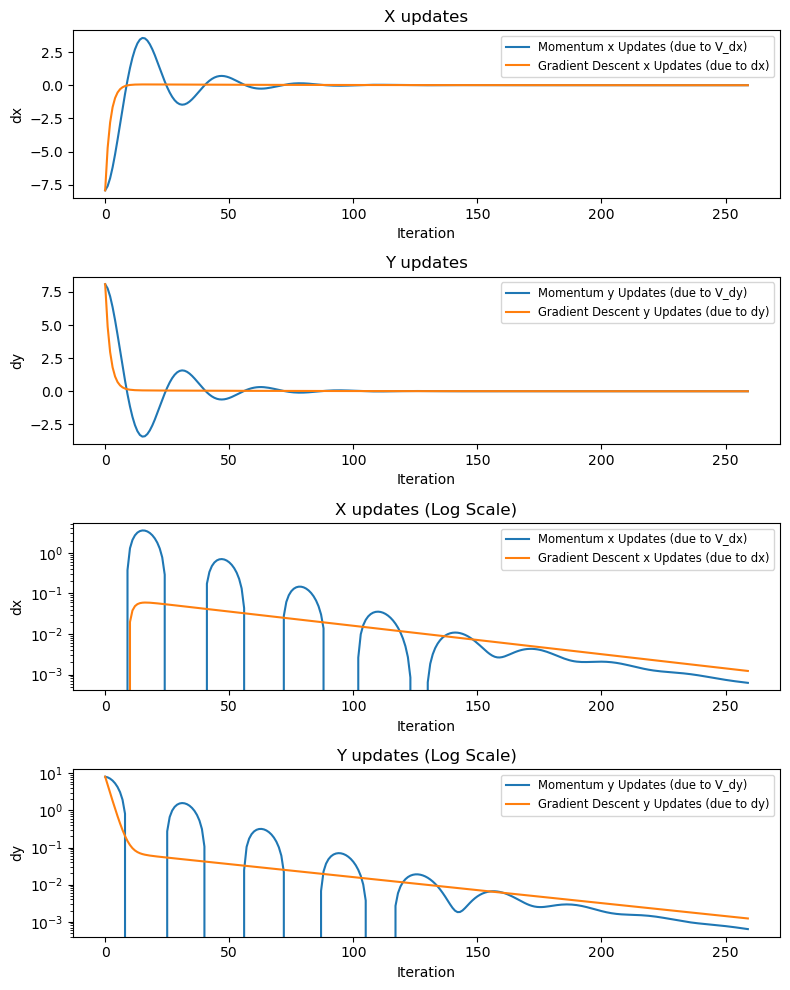

In [4]:
gd_gradients = np.array([point[2] for point in gd])
momentum_gradients = np.array([point[2] for point in momentum])

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(8,10))

ax1.set_title("X updates")
ax1.plot(momentum_gradients[:,0], label='Momentum x Updates (due to V_dx)')
ax1.plot(gd_gradients[:,0], label='Gradient Descent x Updates (due to dx)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('dx')
ax1.legend(fontsize='small')

ax2.set_title("Y updates")
ax2.plot(momentum_gradients[:,1], label='Momentum y Updates (due to V_dy)')
ax2.plot(gd_gradients[:,1], label='Gradient Descent y Updates (due to dy)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('dy')
ax2.legend(fontsize='small')

ax3.set_title("X updates (Log Scale)")
ax3.plot(momentum_gradients[:,0], label='Momentum x Updates (due to V_dx)')
ax3.plot(gd_gradients[:,0], label='Gradient Descent x Updates (due to dx)')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('dx')
ax3.set_yscale('log')
ax3.legend(fontsize='small')

ax4.set_title("Y updates (Log Scale)")
ax4.plot(momentum_gradients[:,1], label='Momentum y Updates (due to V_dy)')
ax4.plot(gd_gradients[:,1], label='Gradient Descent y Updates (due to dy)')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('dy')
ax4.set_yscale('log')
ax4.legend(fontsize='small')

plt.tight_layout()
plt.show()

Looking at the above, if we focus on the normal scale plots, it would seem like the parameter updates in the case of gradient descent seem more straightforward and converge to zero faster than in the case of momentum. However this is not necessarily the case as we will see soon.

Here, we can also clearly see that the weighted average updates (V_dx and v_dy) are more resilient to sudden changes in the gradient value due to which they don't react as quickly to changes in the value of the gradient updates in the opposite direction as they normally would if considering just the gradients. This leads to the momentum updates occuring in a meandering manner as opposed to hyperfocusing towards the minimum.

Now, converting the y-axis to a logarithmic scale allows us to take a closer look at the updates as they approach zero. Here we see that the parameter updates for momentum eventually go lower than the updates for normal gradient descent. This in contrast to what we notice during the initial analysis of the curves in normal scale.

To understand the overall effect these parameter updates have on the root finding process we have to see how they affect the cost function at each iteration, which is given by the output below.

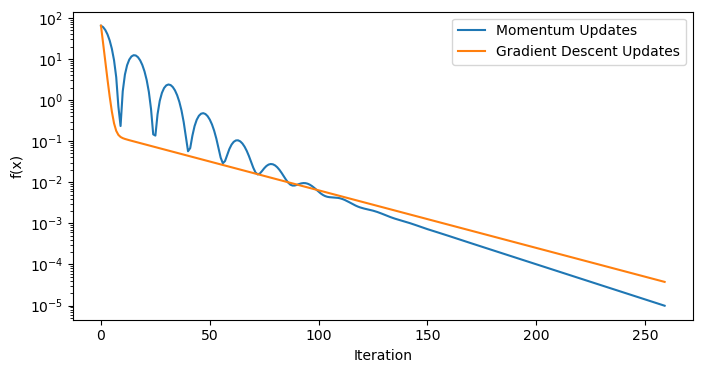

In [5]:
fig = plt.figure(figsize=(8,4))
gd_updates = np.array([point[1] for point in gd])
momentum_updates = np.array([point[1] for point in momentum])
plt.plot(momentum_updates[:], label='Momentum Updates')
plt.plot(gd_updates[:], label='Gradient Descent Updates')
plt.yscale('log')
plt.xlabel(r'Iteration')
plt.ylabel(r'f(x)')
plt.legend()
plt.show()

We see that the momentum updates to f(x), though initially erratic, gradually end up moving faster towards the minimum value of 0 than normal gradient descent as the weighted average preserves its momentum, even if subsequent gradient values get extremely smaller.

## Effects of RMSProp on the loss function

Similar to the previous section, we will now have a look at how RMSProp affects our root finding process starting with the parameter updates.

Here, RMSProp focuses on the learning rate during the parameter updating process as opposed to affecting the actual parameters in the case of Momentum.

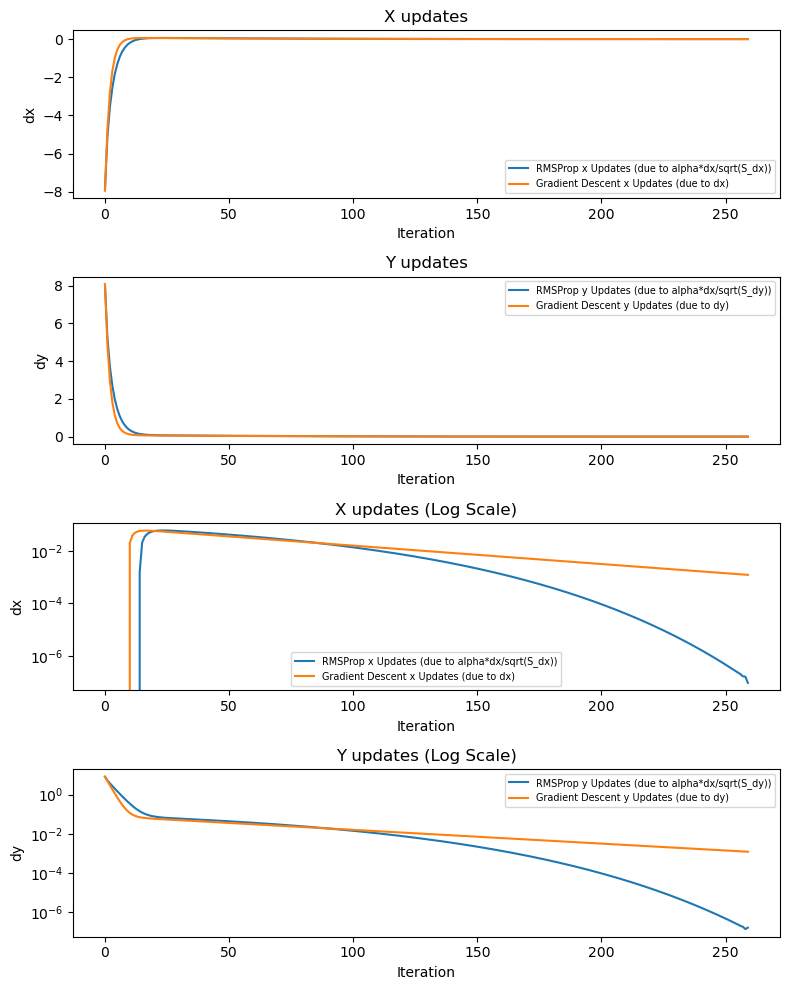

In [6]:
gd_gradients = np.array([point[2] for point in gd])
rmsprop_gradients = np.array([point[2] for point in rmsprop])

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(8,10))

ax1.set_title("X updates")
ax1.plot(rmsprop_gradients[:,0], label='RMSProp x Updates (due to alpha*dx/sqrt(S_dx))')
ax1.plot(gd_gradients[:,0], label='Gradient Descent x Updates (due to dx)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('dx')
ax1.legend(fontsize='x-small')

ax2.set_title("Y updates")
ax2.plot(rmsprop_gradients[:,1], label='RMSProp y Updates (due to alpha*dx/sqrt(S_dy))')
ax2.plot(gd_gradients[:,1], label='Gradient Descent y Updates (due to dy)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('dy')
ax2.legend(fontsize='x-small')

ax3.set_title("X updates (Log Scale)")
ax3.plot(rmsprop_gradients[:,0], label='RMSProp x Updates (due to alpha*dx/sqrt(S_dx))')
ax3.plot(gd_gradients[:,0], label='Gradient Descent x Updates (due to dx)')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('dx')
ax3.set_yscale('log')
ax3.legend(fontsize='x-small')

ax4.set_title("Y updates (Log Scale)")
ax4.plot(rmsprop_gradients[:,1], label='RMSProp y Updates (due to alpha*dx/sqrt(S_dy))')
ax4.plot(gd_gradients[:,1], label='Gradient Descent y Updates (due to dy)')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('dy')
ax4.set_yscale('log')
ax4.legend(fontsize='x-small')

plt.tight_layout()
plt.show()

Here we note a significant drop in the value of the updates occuring with each iteration. However, this doesn't tell us much about what is happening with the loss function.

Instead, we need to focus on the value of the learning rate with each iteration. To be more precise, we need to focus on how the learning rate changes throughout the training process.

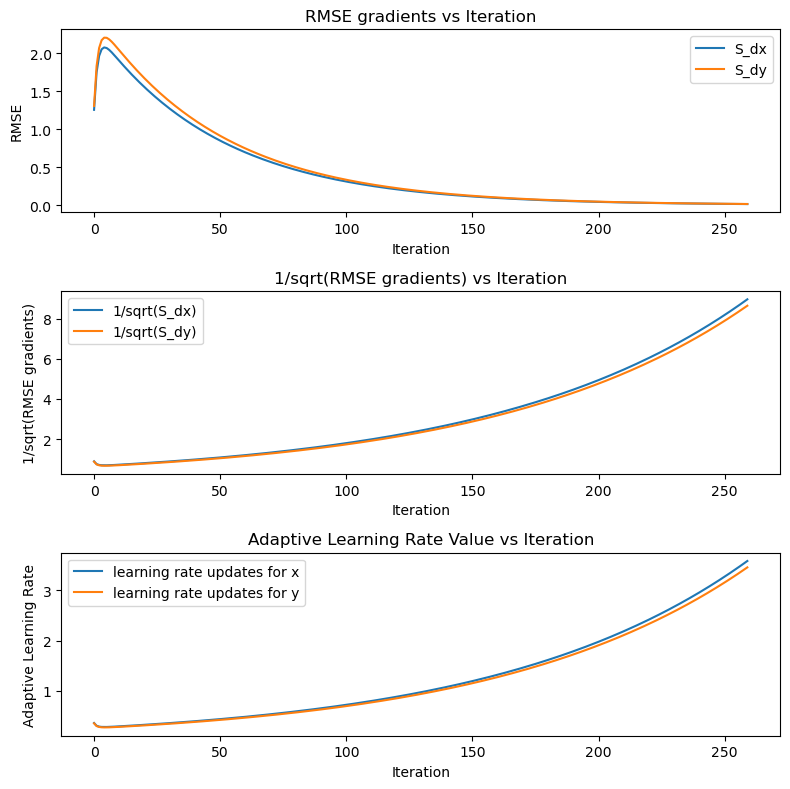

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(8,8))
rmsprop_lrs = np.array([point[4] for point in rmsprop])
rmsprop_sda = np.array([point[3] for point in rmsprop])

ax1.set_title("RMSE gradients vs Iteration")
ax1.plot(rmsprop_sda[:,0], label='S_dx')
ax1.plot(rmsprop_sda[:,1], label='S_dy')
ax1.set_xlabel(r'Iteration')
ax1.set_ylabel(r'RMSE')
ax1.legend()

ax2.set_title("1/sqrt(RMSE gradients) vs Iteration")
ax2.plot(1/(np.sqrt(rmsprop_sda[:,0]) + 10**(-7)), label='1/sqrt(S_dx)')
ax2.plot(1/(np.sqrt(rmsprop_sda[:,1]) + 10**(-7)), label='1/sqrt(S_dy)')
ax2.set_xlabel(r'Iteration')
ax2.set_ylabel(r'1/sqrt(RMSE gradients)')
ax2.legend()

ax3.set_title("Adaptive Learning Rate Value vs Iteration")
ax3.plot(rmsprop_lrs[:,0], label='learning rate updates for x')
ax3.plot(rmsprop_lrs[:,1], label='learning rate updates for y')
ax3.set_xlabel(r'Iteration')
ax3.set_ylabel(r'Adaptive Learning Rate')
ax3.legend()

plt.tight_layout()
plt.show()

Here, we see that the learning rate increases to values much higher than the default value that has been set initially as the optimization algorithm approaches 250 iterations.

This amplifies the size of the steps taken by the gradients greatly as the values of the gradients themselves approach the minimum.

The overall effect this on the cost function is given below.

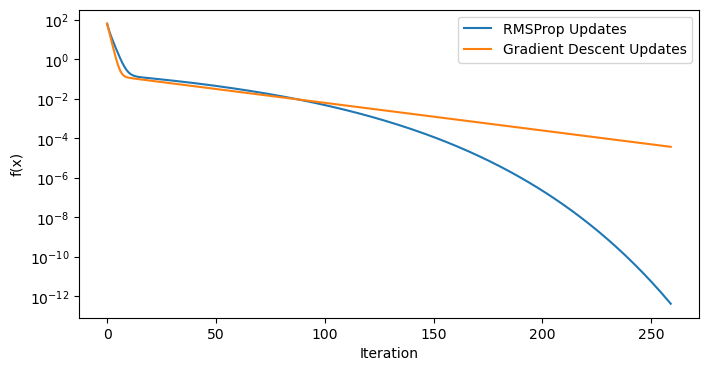

In [8]:
fig = plt.figure(figsize=(8,4))
gd_updates = np.array([point[1] for point in gd])
rmsprop_updates = np.array([point[1] for point in rmsprop])
plt.plot(rmsprop_updates[:], label='RMSProp Updates')
plt.plot(gd_updates[:], label='Gradient Descent Updates')
plt.yscale('log')
plt.xlabel(r'Iteration')
plt.ylabel(r'f(x)')
plt.legend()
plt.show()

Here we notice an extreme drop in the loss function past 100 iterations as opposed to gradient descent. This shows how effective RMSProp is in comparison to normal gradient descent.

## The ADAM Optimizer

The ADAM Optimizer implements concepts from both Momentum and ADAMProp, changing both, the learning rate and the gradient updates with every iteration. This hence leads to an implementation of momentum alongside an effective dampening of the updates occuring in directions other than towards the minimum.

The curve below shows how the updates in the loss function looks in this case 

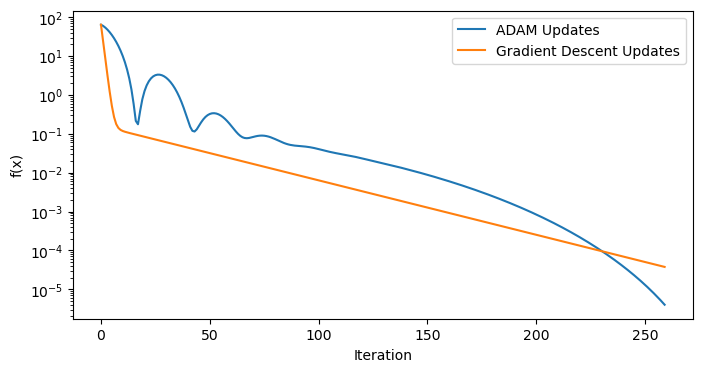

In [9]:
fig = plt.figure(figsize=(8,4))
gd_updates = np.array([point[1] for point in gd])
adam_updates = np.array([point[1] for point in adam])
plt.plot(adam_updates[:], label='ADAM Updates')
plt.plot(gd_updates[:], label='Gradient Descent Updates')
plt.yscale('log')
plt.xlabel(r'Iteration')
plt.ylabel(r'f(x)')
plt.legend()
plt.show()

Here we see that the loss function for the ADAM optimizer possesses the momemtum-like characteristics from gradient descent with momentum. In addition, the effect of the RMSProp part ensures that the learning rate compounds as the learning curve approaches the minimum.

The effect here is that the jumps in the learning process attributed to the momentum mechanism are constrained by the adaptive learning rate which is constantly monitoring the RMS gradient value. This effectively dampens the oscillations of the loss curve, focusing it to learn faster in the direction of the root of the loss function.

Finally, we can compare all of the loss function values for each of the curves

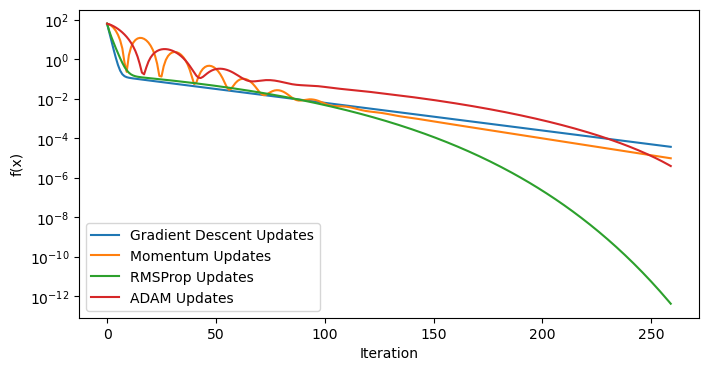

In [10]:
fig = plt.figure(figsize=(8,4))
plt.plot(gd_updates[:], label='Gradient Descent Updates')
plt.plot(momentum_updates[:], label='Momentum Updates')
plt.plot(rmsprop_updates[:], label='RMSProp Updates')
plt.plot(adam_updates[:], label='ADAM Updates')
plt.yscale('log')
plt.xlabel(r'Iteration')
plt.ylabel(r'f(x)')
plt.legend()
plt.show()

The above curves have only been run for a small window of time (260 iterations to be exact). Hence it seems like the curves will continue to descent till they reach a miniscule value. However this is not necessarily the case.

Let us do the same but with the number of iterations being set to $4000$.

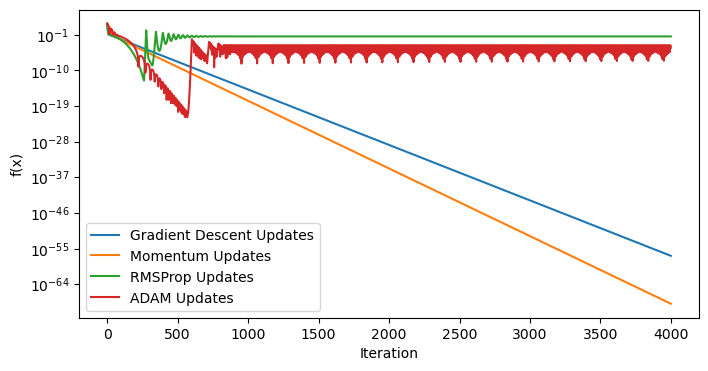

In [11]:
gd1 = descend(np.array([-6,10]), iter=4000)
momentum1 = descend(np.array([-6,10]),beta1=0.9, optimizer='momentum', iter=4000)
rmsprop1 = descend(np.array([-6,10]), optimizer='rmsprop', iter=4000)
adam1 = descend(np.array([-6,10]),beta1=0.9, optimizer='adam', iter=4000)

gd_updates1 = np.array([point[1] for point in gd1])
momentum_updates1 = np.array([point[1] for point in momentum1])
rmsprop_updates1 = np.array([point[1] for point in rmsprop1])
adam_updates1 = np.array([point[1] for point in adam1])

fig = plt.figure(figsize=(8,4))
plt.plot(gd_updates1[:], label='Gradient Descent Updates')
plt.plot(momentum_updates1[:], label='Momentum Updates')
plt.plot(rmsprop_updates1[:], label='RMSProp Updates')
plt.plot(adam_updates1[:], label='ADAM Updates')
plt.yscale('log')
plt.xlabel(r'Iteration')
plt.ylabel(r'f(x)')
plt.legend()
plt.show()

We finally pit these algorithms against one another to see how they behave on the actual loss functions' surface.

The code below generates animations showing us the paths followed by each of the optimization algorithms. Make sure you change the last part of the first cell in this notebook to 

```python
%matplotlib qt
# %matplotlib inline
```
before running this part, otherwise you will be shown a static image of the first frame of the animation.

In [ ]:
x = np.arange (-10,10,1)
y = np.arange (-10,12,1)

x,y = np.meshgrid(x,y)

z = 0.26*(x**2 + y**2) - 0.48*x*y

fig= plt.figure(figsize = (5,5), dpi=300)

ax = plt.axes(projection="3d")

ax.set(xlim=[-3.5, 3.5], ylim=[-3.5, 3.5], xlabel='x', ylabel='y')
ax.view_init(50,-130)
# ax.set_box_aspect(None, zoom=3)
gd_points = np.array([(point[0][0],point[0][1],point[1]) for point in gd])
momentum_points = np.array([(point[0][0],point[0][1],point[1]) for point in momentum])
rmsprop_points = np.array([(point[0][0],point[0][1],point[1]) for point in rmsprop])
adam_points = np.array([(point[0][0],point[0][1],point[1]) for point in adam])
ax.plot_surface(x,y,z, cmap=cm.Wistia, alpha =0.4)
ax.scatter(0, 0, 0, color='black', s=10, marker='*', label='Minimum')
gd_line, = ax.plot(gd_points[:,0],gd_points[:,1],gd_points[:,2], label = "GD", color="crimson", zorder = 3, linewidth = 1, alpha = 0.6)
momentum_line, = ax.plot(momentum_points[:,0],momentum_points[:,1],momentum_points[:,2], label = "Momentum", color="blue", zorder = 2, linewidth = 1, alpha = 0.7)
rmsprop_line, = ax.plot(rmsprop_points[:,0],rmsprop_points[:,1],rmsprop_points[:,2], label = "RmsProp", color="orange", zorder = 1, linewidth = 1, alpha = 0.8)
adam_line, = ax.plot(adam_points[:,0],adam_points[:,1],adam_points[:,2], label = "ADAM", color="green", zorder = 1, linewidth = 1, alpha = 0.8)
gd_value = ax.text2D(0.85, 0.97, f"GD f(x) = {gd_points[0][2]}", transform=ax.transAxes, ha='left', fontsize=5)
momentum_value = ax.text2D(0.85, 0.94, f"Momentum f(x) = {momentum_points[0][2]}", transform=ax.transAxes, ha='left', fontsize=5)
rmsprop_value = ax.text2D(0.85, 0.91, f"RMSProp f(x) = {rmsprop_points[0][2]}", transform=ax.transAxes, ha='left', fontsize=5)
adam_value = ax.text2D(0.85, 0.88, f"ADAM f(x) = {adam_points[0][2]}", transform=ax.transAxes, ha='left', fontsize=5)


def update(frame):

    gd_line.set_xdata(gd_points[:frame,0])
    gd_line.set_ydata(gd_points[:frame,1])
    gd_line.set_3d_properties(gd_points[:frame,2])
    momentum_line.set_xdata(momentum_points[:frame,0])
    momentum_line.set_ydata(momentum_points[:frame,1])
    momentum_line.set_3d_properties(momentum_points[:frame,2])
    rmsprop_line.set_xdata(rmsprop_points[:frame,0])
    rmsprop_line.set_ydata(rmsprop_points[:frame,1])
    rmsprop_line.set_3d_properties(rmsprop_points[:frame,2])
    adam_line.set_xdata(adam_points[:frame,0])
    adam_line.set_ydata(adam_points[:frame,1])
    adam_line.set_3d_properties(adam_points[:frame,2])

    gd_value.set_text( f"GD f(x) = {gd_points[frame][2]:.4f}")
    momentum_value.set_text( f"Momentum f(x) = {momentum_points[frame][2]:.4f}")
    rmsprop_value.set_text( f"RMSProp f(x) = {rmsprop_points[frame][2]:.4f}")
    adam_value.set_text( f"ADAM f(x) = {adam_points[frame][2]:.4f}")

    plt.legend(loc=3, fontsize=5)

    return (gd_line, momentum_line, rmsprop_line, adam_line)

anim = animation.FuncAnimation(fig=fig, func=update, frames=len(adam), interval=100)

# The code below converts this animation into a gif for web viewing. I used the same
# to generate the animated gifs for my blog

# anim.save(filename="../video/gradients_2.gif", writer="pillow")

# plt.legend(loc=3, fontsize=5)
# plt.show()